In [1]:
import torch
import torch.nn as nn
from pau import PAU

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator as Interp2D

from pathlib import Path
import gc

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred'
FIGURES_BASIS = FIGURES / 'basis'
FIGURES_KERNEL = FIGURES / 'kernel'
FIGURES_ERROR = FIGURES / 'error'
FIGURES_EIGV = FIGURES / 'eigv'


FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)


torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
def Gaussian_Quadrature(n):
    int_p_1d, int_w_1d = np.polynomial.legendre.leggauss(n)
    int_p_1d = (1 + torch.tensor(int_p_1d).float())/2
    int_w_1d = 0.5*torch.tensor(int_w_1d).float()
    
    int_p = torch.stack(torch.meshgrid((int_p_1d, int_p_1d), indexing='xy')).reshape(2, -1).float()
    int_w = torch.einsum('i,j->ij', int_w_1d, int_w_1d).ravel().float()

    return int_p, int_w, int_p_1d, int_w_1d

In [3]:
def Trapezoidal_Rule(n):
    int_p_1d = torch.linspace(0, 1, n)
    int_w_1d = torch.ones(n)
    int_w_1d[[0, -1]] /= 2

    int_p = torch.stack(torch.meshgrid(int_p_1d, int_p_1d, indexing='xy')).view(2, -1)
    int_w = (torch.kron(int_w_1d, int_w_1d) * (1/(n-1))**2).ravel()

    return int_p, int_w, int_p_1d, int_w_1d

In [4]:
def init_sequential(layers):
    modules = []
    for i in range(len(layers)-2):
        modules.append(nn.Linear(layers[i], layers[i+1]))
        modules.append(PAU(initial_shape='relu'))
    modules.append(nn.Linear(layers[-2], layers[-1]))
    return nn.Sequential(*modules)

In [5]:
model_data = torch.load('dataset/ds20k/model/23000_ds20k_basis_8basis.model')

Basis_approximator = init_sequential([10000, 8])
Basis_trunk = init_sequential([2, 100, 100, 100, 100, 8])

Basis_approximator.load_state_dict(model_data['A'][0])
Basis_trunk.load_state_dict(model_data['T'][0])
Basis_epoch = model_data['epoch']

In [6]:
model_data = torch.load('dataset/ds20k/model/2000_basis_enc_qs30_fixed.model')

Basis_enc_approximator = init_sequential([100, 8])
Basis_enc_trunk = init_sequential([2, 100, 100, 100, 100, 8])

Basis_enc_approximator.load_state_dict(model_data['A'][0])
Basis_enc_trunk.load_state_dict(model_data['T'][0])
Basis_enc_epoch = model_data['epoch']

In [7]:
def build_net(layers):
    modules = []
    for i in range(len(layers)-1):
        modules.append(nn.Linear(layers[i], layers[i+1]))
        modules.append(PAU(initial_shape='relu'))

    net = nn.Sequential(*modules)
    opt = torch.optim.Adam(net.parameters())

    return net, opt

green_net, _ = build_net([4, 100, 100, 100, 100, 1])

model_data = torch.load('dataset/ds20k/model/100_ds20k_kernel_10qs.model')

green_net.load_state_dict(model_data['net'])
Kernel_epoch = model_data['epoch']

green_net_original = green_net
green_net = torch.compile(green_net)

In [8]:
def Basis_model(xb, p):
    A = Basis_approximator(xb)         # -> [bs]x[lat_dim]
    D = Basis_trunk(p.T)               # -> [points]x[lat_dim]
    return A @ D.T

In [9]:
def Kernel_model(x, t):
    '''
        Computes x(t) = int k(t,s) x(s) ds
    '''
    result = torch.zeros(x.shape[0], t.shape[1])
    for j, t1t2 in enumerate(t.T):
        t1t2_rep = t1t2.repeat((int_p.shape[1], 1)).T
        Kt1t2s1s2 = green_net(torch.cat((t1t2_rep, int_p)).T).squeeze()

        for i, xi in enumerate(x):
            result[i, j] = (xi * Kt1t2s1s2) @ int_w

    return result

In [10]:
def Basis_enc_model(xb, p):
    A = Basis_enc_approximator(xb)         # -> [bs]x[lat_dim]
    D = Basis_enc_trunk(p.T)               # -> [points]x[lat_dim]
    return A @ D.T

# Predictions

In [11]:
N = 100
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).view(2, -1)

Q = 20
int_p, int_w, int_p_1d, int_w_1d = Gaussian_Quadrature(Q)

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_r

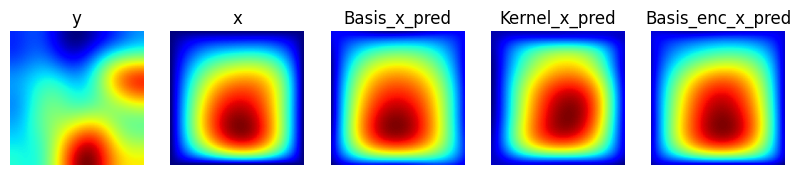

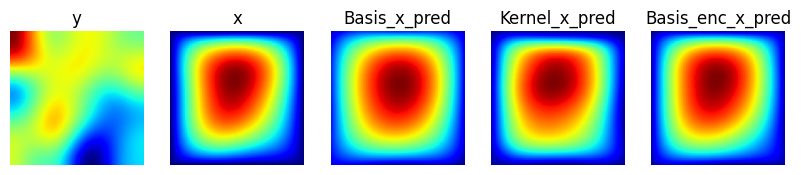

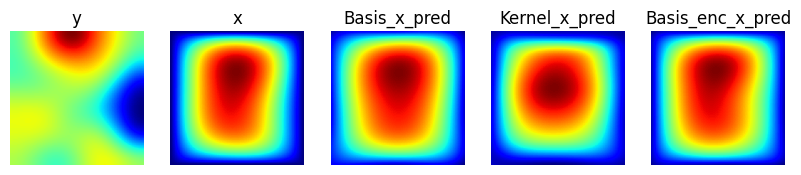

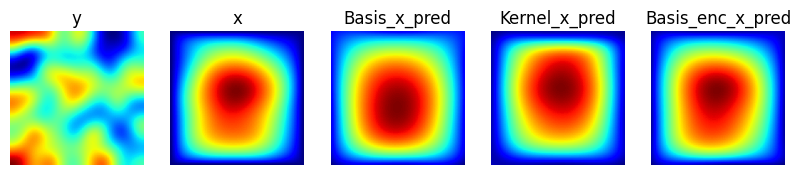

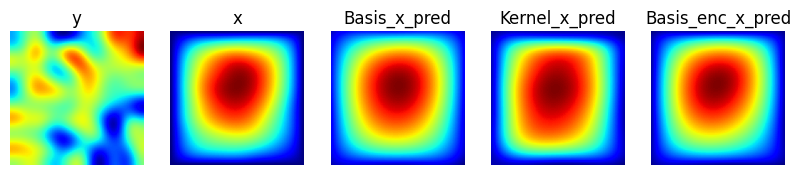

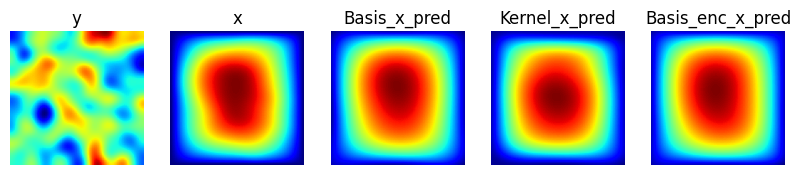

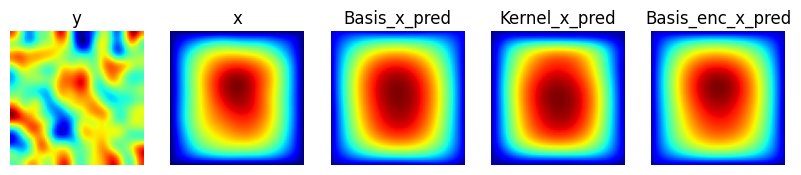

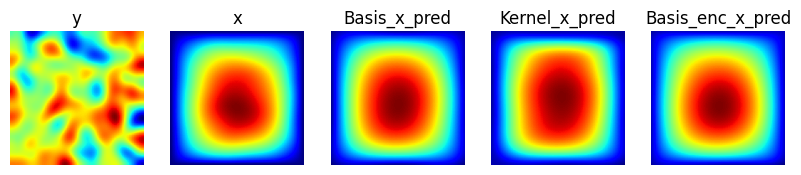

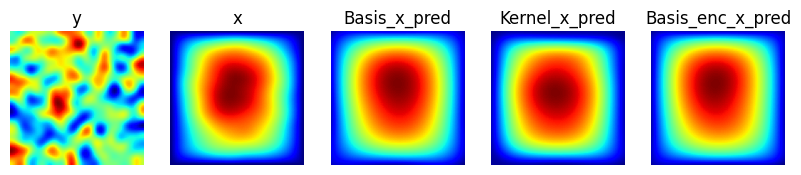

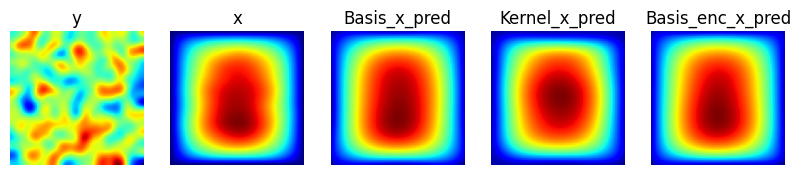

In [12]:
Basis_valid_ds = torch.load('dataset/ds20k/valid/ds20k_basis_8basis.ds')
Basis_enc_valid_ds = torch.load('dataset/ds20k/valid/basis_enc_qs30_fixed.ds')
Kernel_valid_ds = torch.load('dataset/ds20k/valid/ds20k_kernel_10qs.ds')

size = len(Basis_valid_ds[0])

for j, i in enumerate(range(0, size, size//10)):
    Basis_y = Basis_valid_ds[0][i]
    Basis_x_pred = Basis_model(Basis_y.unsqueeze(dim=0), tt).squeeze()

    Kernel_y = Kernel_valid_ds[0][i]
    Kernel_y = Interp2D(
        (np.linspace(0, 1, 9), np.linspace(0, 1, 9)),
        Kernel_y.view(9, 9).numpy())(int_p.T.numpy())
    Kernel_y = torch.tensor(Kernel_y).float()
    Kernel_x_pred = Kernel_model(Kernel_y.unsqueeze(dim=0), tt).squeeze()

    Basis_enc_y = Basis_enc_valid_ds[0][i]
    Basis_enc_x_pred = Basis_enc_model(Basis_enc_y.unsqueeze(dim=0), tt).squeeze()

    x = torch.load(f'dataset/ds20k/valid/{i}_X.pt')
    y = torch.load(f'dataset/ds20k/valid/{i}_Y.pt')

    y = Interp2D(
        (np.linspace(0, 1, 100), np.linspace(0, 1, 100)),
        y.numpy())(tt.T.numpy())
    x = Interp2D(
        (np.linspace(0, 1, 100), np.linspace(0, 1, 100)),
        x.numpy())(tt.T.numpy())
    

    '''  Show All  '''
    fig, ax = plt.subplots(ncols=5, figsize=(10, 8))
    
    ax[0].imshow(y.reshape(N,N), cmap='jet')
    ax[0].set_title('y')
    ax[1].imshow(x.reshape(N,N), cmap='jet')
    ax[1].set_title('x')
    ax[2].imshow(Basis_x_pred.reshape(N, N), cmap='jet')
    ax[2].set_title('Basis_x_pred')
    ax[3].imshow(Kernel_x_pred.reshape(N, N), cmap='jet')
    ax[3].set_title('Kernel_x_pred')
    ax[4].imshow(Basis_enc_x_pred.reshape(N, N), cmap='jet')
    ax[4].set_title('Basis_enc_x_pred')

    ax[0].axis('off'); ax[1].axis('off'); 
    ax[2].axis('off'); ax[3].axis('off');
    ax[4].axis('off');

    plt.show()
    plt.close('all')

    '''  Save Individual Files  '''
    def compute_ticks(a):
        return [a.min(), a.mean(), a.max()]
    
    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(y.reshape(N, N), cmap='jet')
    plt.title(r'$y$')
    plt.axis('off')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(y))
    plt.savefig(FIGURES_PRED / f'y_#Fig{j}_with_title.png', bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(x.reshape(N, N), cmap='jet')
    plt.title(r'$x$')
    plt.axis('off')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(x))
    plt.savefig(FIGURES_PRED / f'x_#Fig{j}_with_title.png', bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(Basis_x_pred.reshape(N, N), cmap='jet')
    plt.title(r'$S^1_{\theta}$ prediction')
    plt.axis('off')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(Basis_x_pred))
    plt.savefig(FIGURES_PRED / f'Basis_x_#epoch{Basis_epoch}_#Fig{j}_with_title.png', bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(Kernel_x_pred.reshape(N, N), cmap='jet')
    plt.title(r'$S^2_{\theta}$ prediction')
    plt.axis('off')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(Kernel_x_pred))
    plt.savefig(FIGURES_PRED / f'Kernel_x_#epoch{Kernel_epoch}_#Fig{j}_with_title.png', bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(Basis_enc_x_pred.reshape(N, N), cmap='jet')
    plt.title(r'$SS^1_{\theta}$ prediction')
    plt.axis('off')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(Basis_enc_x_pred))
    plt.savefig(FIGURES_PRED / f'Basis_enc_x_#epoch{Basis_enc_epoch}_#Fig{j}_with_title.png', bbox_inches='tight')
    plt.close()

    gc.collect(2)

# Basis Extraction

In [13]:
gc.collect(2)

22165

In [14]:
class Function:
    def __init__(self, f1: callable = None):
        self.expr = []
        if f1: self.expr.append(f1)

    def copy(self):
        f = Function()
        f.expr = self.expr.copy()
        return f

    def __call__(self, x, *args, **kwargs):
        ans = self.expr[0](x)
        other = None
        for e in self.expr[1:]:
            if callable(e):
                other = e(x)
            elif not isinstance(e, str):
                other = e
            else:
                match e:
                    case '+': ans = ans + other
                    case '-': ans = ans - other
                    case '*': ans = ans * other
                    case '/': ans = ans / other
                    case '//': ans = ans // other
        return ans

    def __add_expr(self, other, expr: str):
        fun1 = Function()
        fun1.expr = self.expr.copy()

        if callable(other):
            fun2 = Function()
            fun2.expr = other.expr.copy()
            fun1.expr.append(fun2)
        elif isinstance(other, (int, float, complex)):
            fun1.expr.append(other)
        else:
            fun1.expr.append(other)

        fun1.expr.append(expr)

        return fun1

    def __add__(self, other): return self.__add_expr(other, '+')
    def __sub__(self, other): return self.__add_expr(other, '-')
    def __mul__(self, other): return self.__add_expr(other, '*')
    def __truediv__(self, other): return self.__add_expr(other, '/')
    def __div__(self, other): return self.__add_expr(other, '//')

In [15]:
def GramSchmidt(BASIS):
    V = BASIS
    n = len(V)
    Q = [None for _ in range(n)]
    R = [[0.0 for __ in range(n)] for _ in range(n)]
    
    for i in range(n):
        R[i][i] = torch.sqrt((V[i](int_p.T) * V[i](int_p.T)) @ int_w)
        Q[i] = V[i] / R[i][i]
        for j in range(i+1, n):
            R[i][j] = (V[j](int_p.T) * Q[i](int_p.T)) @ int_w
            if abs(R[i][j]) >= 1e-6:
                V[j] = V[j] - (Q[i] * R[i][j])
    return np.array(Q), R

## Basis Model

In [16]:
def Basis_compute_eigv(BASIS):
    EIGV = []
    for i, b in enumerate(BASIS):
        b_int = b(int_p.T)
        num = (b_int * Basis_model(b(tt.T).unsqueeze(dim=0), int_p)) @ int_w
        den = (b_int * b_int) @ int_w
        EIGV.append(num / den)
    return torch.tensor(EIGV)

In [17]:
Basis_basis = []

Basis_trunk_eval = Basis_trunk(tt.T).T
for b in Basis_trunk_eval:
    def fun(x, b=b):
        return torch.tensor(Interp2D((t.numpy(), t.numpy()), b.reshape(N, N).numpy())(x)).float()
    Basis_basis.append(Function(fun))

Basis_basis = np.array(Basis_basis)
Basis_eigv = Basis_compute_eigv(Basis_basis)

idx = torch.argsort(Basis_eigv, descending=True)

Basis_eigv[:] = Basis_eigv[idx]
Basis_basis[:] = Basis_basis[idx]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6400 and 10000x8)

In [ ]:
Basis_obasis, _ = GramSchmidt(Basis_basis)
Basis_oeigv = Basis_compute_eigv(Basis_obasis)

idx = torch.argsort(Basis_oeigv, descending=True)

Basis_oeigv[:] = Basis_oeigv[idx]
Basis_obasis[:] = Basis_obasis[idx]

## Kernel Model

In [ ]:
Kernel_kernel = torch.zeros(N**2, N**2)

for k, t1t2 in enumerate(tt.T):
    t1t2_expand = t1t2.expand(N**2, -1).T
    input = torch.cat((t1t2_expand, tt)).T
    Kernel_kernel[k] = green_net(input).squeeze()

In [ ]:
U, S, _ = torch.linalg.svd(Kernel_kernel)

Kernel_basis = U[:, :8]
Kernel_eigv = sorted(1/S[:8], reverse=True)

In [ ]:
V = Kernel_basis.T
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]
_, int_w_aux, _, _ = Trapezoidal_Rule(N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-6:
            V[j] = V[j] - (Q[i] * R[i][j])

In [ ]:
Kernel_obasis = np.array(Q)

## Basis Enc Model

In [ ]:
def Basis_enc_compute_encoding(b):
    b_int = b(int_p.T)
    b_enc = torch.zeros(10*10)
    k = 0
    for i in range(1, 11):
        for j in range(1, 11):
            k1 = torch.tensor(i)
            k2 = torch.tensor(j)
            fun1 = torch.sin(torch.pi * k1 * int_p[0])
            fun2 = torch.sin(torch.pi * k2 * int_p[1])
            num = (fun1 * fun2 * b_int) @ int_w
            den = torch.sqrt((fun1 * fun2)**2 @ int_w)
            b_enc[k] = num / den
            k += 1
    return b_enc

In [ ]:
def Basis_enc_compute_eigv(BASIS):
    EIGV = []
    for i, b in enumerate(BASIS):
        b_int = b(int_p.T)
        b_enc = Basis_enc_compute_encoding(b)
        
        num = (b_int * Basis_enc_model(b_enc.unsqueeze(dim=0), int_p)) @ int_w
        den = (b_int * b_int) @ int_w
        EIGV.append(num / den)
    return torch.tensor(EIGV)

In [ ]:
Basis_enc_basis = []

Basis_enc_trunk_eval = Basis_enc_trunk(tt.T).T
for b in Basis_enc_trunk_eval:
    def fun(x, b=b):
        return torch.tensor(Interp2D((t.numpy(), t.numpy()), b.reshape(N, N).numpy())(x)).float()
    Basis_enc_basis.append(Function(fun))

Basis_enc_basis = np.array(Basis_enc_basis)
Basis_enc_eigv = Basis_enc_compute_eigv(Basis_enc_basis)

idx = torch.argsort(Basis_enc_eigv, descending=True)

Basis_enc_eigv[:] = Basis_enc_eigv[idx]
Basis_enc_basis[:] = Basis_enc_basis[idx]

In [ ]:
Basis_enc_obasis, _ = GramSchmidt(Basis_enc_basis)
Basis_enc_oeigv = Basis_enc_compute_eigv(Basis_enc_obasis)

idx = torch.argsort(Basis_enc_oeigv, descending=True)

Basis_enc_oeigv[:] = Basis_enc_oeigv[idx]
Basis_enc_obasis[:] = Basis_enc_obasis[idx]

## Real Basis

In [ ]:
Real_basis = []
Real_eigv = []

for i in range(1, 11):
    for j in range(1, 11):
        k1 = torch.tensor(i)
        k2 = torch.tensor(j)
        fun1 = torch.sin(torch.pi * k1 * tt[0])
        fun2 = torch.sin(torch.pi * k2 * tt[1])
        fun1_int = torch.sin(torch.pi * k1 * int_p[0])
        fun2_int = torch.sin(torch.pi * k1 * int_p[1])
        num = fun1 * fun2
        den = torch.sqrt((fun1_int * fun2_int)**2 @ int_w)
        Real_basis.append(num / den)
        Real_eigv.append( 1 / ((torch.pi*k1)**2 + (torch.pi*k2)**2) )

Real_basis = torch.stack(Real_basis)
Real_eigv = torch.tensor(Real_eigv)

idx = torch.argsort(Real_eigv, descending=True)[:8]

Real_eigv = Real_eigv[idx]
Real_basis = Real_basis[idx]

In [ ]:
del Basis_basis, Basis_eigv
del Basis_enc_basis, Basis_enc_eigv
del Kernel_basis
gc.collect(2)

## Plotting

In [ ]:
'''  Save Separate Files  '''
gc.collect(2)

def compute_ticks(a):
    return [a.min(), a.mean(), a.max()]

for i in range(8):
    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(Real_basis[i].reshape(N, N), cmap='jet')
    plt.title(f'Exact basis {i+1}')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(Real_basis[i]))
    plt.axis('off')
    plt.savefig(FIGURES_BASIS / f'#Fig_{i}_with_title.png', bbox_inches='tight')
    plt.close()

    img = Basis_obasis[i](tt.T)
    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(img.reshape(N, N), cmap='jet')
    plt.title(r'$S^1_{\theta}$' + f' basis {i+1} at epoch {Basis_epoch}')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(img))
    plt.axis('off')
    plt.savefig(FIGURES_BASIS / f'Basis_#epoch{Basis_epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    plt.close()

    img = Kernel_obasis[i]
    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(img.reshape(N, N), cmap='jet')
    plt.title(r'$S^1_{\theta}$' + f' basis {i+1} at epoch {Kernel_epoch}')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(img))
    plt.axis('off')
    plt.savefig(FIGURES_BASIS / f'Kernel_#epoch{Kernel_epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    plt.close()

    img = Basis_enc_obasis[i](tt.T)
    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.imshow(img.reshape(N, N), cmap='jet')
    plt.title(r'$SS^1_{\theta}$' + f' basis {i+1} at epoch {Basis_enc_epoch}')
    plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(img))
    plt.axis('off')
    plt.savefig(FIGURES_BASIS / f'Basis_enc_#epoch{Basis_enc_epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    plt.close()

    gc.collect(2)

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(Real_eigv, 'or-', label='exact')
plt.plot(Basis_oeigv, 'ob-', label='estimated')
plt.title(r'Eigenvalue estimation by $S^1_{\theta}$ at epoch ' + str(Basis_epoch))
plt.legend()
plt.savefig(FIGURES_EIGV / f'Basis_#epoch{Basis_epoch}_with_title.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(Real_eigv, 'or-', label='exact')
plt.plot(Kernel_eigv, 'ob-', label='estimated')
plt.title(r'Eigenvalue estimation by $S^2_{\theta}$ at epoch ' + str(Kernel_epoch))
plt.legend()
plt.savefig(FIGURES_EIGV / f'Kernel_#epoch{Kernel_epoch}_with_title.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(Real_eigv, 'or-', label='exact')
plt.plot(Basis_enc_oeigv, 'ob-', label='estimated')
plt.title(r'Eigenvalue estimation by $SS^1_{\theta}$ at epoch' + str(Basis_enc_epoch))
plt.legend()
plt.savefig(FIGURES_EIGV / f'Basis_enc_#epoch{Basis_enc_epoch}_with_title.png', bbox_inches='tight')
plt.close()

# Kernel Extraction

In [ ]:
gc.collect(2)

In [ ]:
def compute_kernel_FUN(BASIS, EIGV):
    s = torch.zeros(N**2, N**2)
    for i in range(len(BASIS)):
        s += torch.outer(BASIS[i](tt.T), BASIS[i](tt.T)) * EIGV[i]
    return s

In [ ]:
Trunc_kernel = torch.zeros(N**2, N**2)
for i in range(8):
    Trunc_kernel += torch.outer(Real_basis[i], Real_basis[i]) * Real_eigv[i]

In [ ]:
Basis_kernel = compute_kernel_FUN(Basis_obasis, Basis_oeigv)

In [ ]:
Basis_enc_kernel = compute_kernel_FUN(Basis_enc_obasis, Basis_enc_oeigv)

## Plotting

In [ ]:
'''  Save Separate Files  '''
ticks_position = [i for i in range(0, N**2, N)]
ticks_label = []
for a, i in enumerate(ticks_position):
    col = i % N + (N-1)
    row = i // N
    ticks_label.append(f'({t[row]:.2f},{t[col]:.2f})')

plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.xticks([])
plt.yticks(ticks_position, ticks_label[::-1])
plt.imshow(Trunc_kernel, cmap='jet')
plt.title('Exact truncated kernel')
plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04)
plt.axis('off')
plt.savefig(FIGURES_KERNEL / f'Trunc_#resolution{N}_with_title.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.xticks([])
plt.yticks(ticks_position, ticks_label[::-1])
plt.imshow(Basis_kernel, cmap='jet')
plt.title(r'$S^1_{\theta}$ kernel')
plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04)
plt.axis('off')
plt.savefig(FIGURES_KERNEL / f'Basis_#epoch{Basis_epoch}_#resolution{N}_with_title.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.xticks([])
plt.yticks(ticks_position, ticks_label[::-1])
plt.imshow(Kernel_kernel, cmap='jet')
plt.title(r'$S^2_{\theta}$ kernel')
plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04)
plt.axis('off')
plt.savefig(FIGURES_KERNEL / f'Kernel_#epoch{Kernel_epoch}_#resolution{N}_with_title.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.xticks([])
plt.yticks(ticks_position, ticks_label[::-1])
plt.imshow(Basis_enc_kernel, cmap='jet')
plt.title(r'$SS^1_{\theta}$ kernel')
plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.04)
plt.axis('off')
plt.savefig(FIGURES_KERNEL / f'Basis_enc_#epoch{Basis_enc_epoch}_#resolution{N}_with_title.png', bbox_inches='tight')
plt.close()

# Errors

In [ ]:
gc.collect(2)

In [ ]:
def read_log(file, rf, max_epoch=float('infinity')):
    valid_error = []
    train_error = []
    with open(file) as f:
        for line in f:
            columns = line.split()
            
            epoch = int(columns[1])

            if epoch > max_epoch:
                break

            if epoch % rf == 0:
                valid_error.append(float(columns[7]))
                train_error.append(float(columns[13]))
    return valid_error, train_error

In [ ]:
Basis_rf = Basis_epoch // 10
Basis_log_file = 'dataset/ds20k/model/error_ds20k_basis_8basis.log'
Basis_valid_error, Basis_train_error = read_log(Basis_log_file, Basis_rf, max_epoch=Basis_epoch)

In [ ]:
Kernel_rf = Kernel_epoch // 10
Kernel_log_file = 'dataset/ds20k/model/error_ds20k_kernel_10qs.log'
Kernel_valid_error, Kernel_train_error = read_log(Kernel_log_file, Kernel_rf, max_epoch=Kernel_epoch)

In [ ]:
Basis_enc_rf = Basis_enc_epoch // 10
Basis_enc_log_file = 'dataset/ds20k/model/error_basis_enc_qs30_fixed.log'
Basis_enc_valid_error, Basis_enc_train_error = read_log(Basis_enc_log_file, Basis_enc_rf, max_epoch=Basis_enc_epoch)

In [ ]:
Basis_epoch_timeline = [k for k in range(0, Basis_epoch, Basis_rf)]
Kernel_epoch_timeline = [k for k in range(0, Kernel_epoch, Kernel_rf)]
Basis_enc_epoch_timeline = [k for k in range(0, Basis_enc_epoch, Basis_enc_rf)]

In [ ]:
plt.figure(figsize=(6, 5))
plt.loglog(Basis_epoch_timeline, Basis_valid_error, 'ob-', label='validation error', linewidth=0.5)
plt.loglog(Basis_epoch_timeline, Basis_train_error, 'or-', label='training error', linewidth=0.5)
plt.title(r'$S^1_{\theta}$ training and validation error')
plt.legend()
plt.savefig(FIGURES_ERROR / f'Basis_#epoch{Basis_epoch}_#rf{Basis_rf}_with_title.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6, 5))
plt.loglog(Kernel_epoch_timeline, Kernel_valid_error, 'ob-', label='validation error', linewidth=0.5)
plt.loglog(Kernel_epoch_timeline, Kernel_train_error, 'or-', label='training error', linewidth=0.5)
plt.title(r'$S^2_{\theta}$ training and validation error')
plt.legend()
plt.savefig(FIGURES_ERROR / f'Kernel_#epoch{Kernel_epoch}_#rf{Kernel_rf}_with_title.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6, 5))
plt.loglog(Basis_enc_epoch_timeline, Basis_enc_valid_error, 'ob-', label='validation error', linewidth=0.5)
plt.loglog(Basis_enc_epoch_timeline, Basis_enc_train_error, 'or-', label='training error', linewidth=0.5)
plt.title(r'$SS^1_{\theta}$ training and validation error')
plt.legend()
plt.savefig(FIGURES_ERROR / f'Basis_enc_#epoch{Basis_enc_epoch}_#rf{Basis_enc_rf}_with_title.png', bbox_inches='tight')